In [1]:
import pandas as pd
import numpy as np
from fastai.vision.all import *

from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from PIL import Image

In [2]:
path = Path("/data/datasets/severstal")
df = pd.read_csv(path/'train.csv')

In [9]:
#path = Path("/data/datasets/severstal")
Path.BASE_PATH = path

Getting the list of image names with defects:

In [47]:
path.ls()

(#6) [Path('test_images'),Path('train_images'),Path('train.csv'),Path('masks'),Path('codes.txt'),Path('sample_submission.csv')]

In [52]:
defected_list = list(df.ImageId.unique())

Defining a function to get the categories `defect/no defect` as 1 and 0 respectively:

In [73]:
def name_in_list(image_name):
    if image_name in defected_list:
        return 1
    else:
        return 0

Now, it comes the DataBlock definition. The selected method for the first resizing was `squish` as random crop might get relevant sections of the image (i.e. parts with defects on it) out of the frame, compounded by the fact the image ratio size is significant. (_TODO:_ `pad` might be a better option if there's a way to use `pad_mode=reflection` as shown in https://docs.fast.ai/vision.augment#Resize):

In [ ]:
images = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=using_attr(name_in_list, 'name'),
                 item_tfms=Resize(1600, method='squish'),
                 batch_tfms=aug_transforms(size=700, min_scale=0.8)
                  )

In [ ]:
images.summary(path/'train_images')

In [91]:
dls = images.dataloaders(path/"train_images", batch_size=16)

Setting now our learner:

In [92]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, )

Finding out the proper LR:

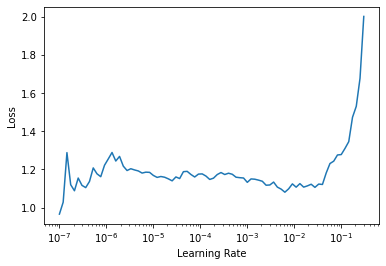

In [93]:
lr_min,lr_steep = learn.lr_find()

In [94]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 6.31e-04, steepest point: 1.91e-06


Let's train with the LR found:

In [102]:
learn.fine_tune(8, base_lr=3e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.919049,0.540379,0.257859,09:07


epoch,train_loss,valid_loss,error_rate,time
0,0.777698,0.483853,0.213689,11:03
1,0.720526,0.428646,0.181854,11:02
2,0.633707,0.354636,0.144449,11:04
3,0.604097,0.328015,0.126542,11:02
4,0.518992,0.383444,0.157979,11:02
5,0.529244,0.305882,0.118583,11:02
6,0.508202,0.292361,0.110227,11:02
7,0.479940,0.286989,0.106645,11:02


Plotting the loss:

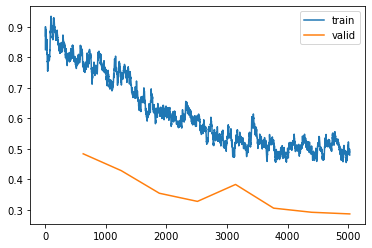

In [103]:
learn.recorder.plot_loss()

In [106]:
learn.export(fname='fine_tuner.pkl')

In [110]:
learn.save('fine_tun_state')

Path('models/fine_tun_state.pth')